#### EngLyser Research
##### Pushkar Sheth | http://phsheth.github.io

In [1]:
import numpy as np
from scipy.fftpack import fft, ifft
from scipy.signal import butter, lfilter
import scipy as sp
import matplotlib.pyplot as plt
from pylab import *

from time import perf_counter
import pandas as pd

from sklearn.cross_validation import train_test_split

from sklearn.ensemble import RandomForestClassifier


%matplotlib qt

C:\Users\phs\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def thetagen(cycles,thetastepsize, forwardoffset):
    thetasingle = np.array(np.arange(0,720,thetastepsize))
    thetarel = np.tile(thetasingle,cycles)
    #thetacum = np.cumsum(thetarel)
    thetacum = np.array(np.arange(0,(720*cycles),thetastepsize))
    #thetacum = thetacum
    return thetasingle, thetarel, thetacum

In [3]:
def gasforcegen(gasforceraw, cycles, thetastepsize,forwardoffset,misfiring):
    thetasingle_deg, thetarel_deg, thetacum_deg = thetagen(cycles,thetastepsize,forwardoffset)
    gasforcerawdata = pd.read_csv(gasforceraw,sep=',',header=None)
    funcakimainterp_gf = sp.interpolate.Akima1DInterpolator(gasforcerawdata[0],gasforcerawdata[1])
    gasforce_theta_deg = funcakimainterp_gf(thetasingle_deg)
    gasforce_theta_deg_cycles = np.tile(gasforce_theta_deg,cycles)
    gasforce_theta_deg_cycles = gasforce_theta_deg_cycles*misfiring
    return gasforce_theta_deg_cycles, thetarel_deg,thetacum_deg

In [4]:
def torquegen(l1_m, l2_m,
              mrod, Izz, lg, mp, engine_speed_rpm, rp_m, 
              gasforcefile, cycles, thetastepsize,forwardoffset,misfiring):
    gasforce_theta_deg_cycles, thetarel_deg,thetacum_deg = gasforcegen(gasforcefile, cycles, thetastepsize,forwardoffset,misfiring)
    #gasforce_theta_deg_cycles = 35*gasforce_theta_deg_cycles/max(gasforce_theta_deg_cycles)
    thetacum_rad = thetacum_deg*np.pi/180
    theta_d = engine_speed_rpm*2*np.pi/60
    theta_dd = 0
    beta = np.arcsin(l1_m*np.sin(thetacum_rad)/l2_m)
    con1 = (1-(np.square(l1_m*np.sin(thetacum_rad)/l2_m)))
    beta_d = (theta_d*l1_m*np.cos(thetacum_rad))/(l2_m*np.sqrt(con1))
    
    a_beta_dd = l1_m*((theta_dd*np.cos(thetacum_rad))-((np.square(theta_d))*np.sin(thetacum_rad)))
    b_beta_dd = l2_m*np.sqrt(con1)
    c_beta_dd = np.square(theta_d)*np.power(l1_m,3)*np.square(np.cos(thetacum_rad))*np.sin(thetacum_rad)
    d_beta_dd = np.power(l2_m,3)*con1
    beta_dd= (a_beta_dd/b_beta_dd)+(c_beta_dd/d_beta_dd)

    a_vpis = (l1_m*theta_d*np.sin(thetacum_rad))
    b_vpis = (np.square(l1_m)*theta_d*np.sin(2*thetacum_rad))
    c_vpis = 2*l2_m*np.sqrt(con1)
    vpis = -a_vpis-(b_vpis/c_vpis)
    
    a_arx = l1_m*theta_dd*np.sin(thetacum_rad)
    b_arx = l1_m*(np.square(theta_d))*np.cos(thetacum_rad)
    c_arx = theta_dd*lg*np.square(l1_m)*np.sin(2*thetacum_rad)
    d_arx = 2*np.square(l2_m)*np.sqrt(con1)
    e_arx = np.square(l2_m)*(2*con1)
    f_arx = np.square(theta_d*l1_m)*lg
    g_arx = 2*np.cos(2*thetacum_rad)*np.sqrt(con1)
    h_arx = np.square(l1_m*np.sin(2*thetacum_rad))
    i_arx = 2*np.square(l2_m)*np.sqrt(con1)
    arx = -a_arx-b_arx-(c_arx/d_arx)-(1/e_arx)*f_arx*(g_arx+(h_arx/i_arx))
    
    a_ary = l1_m*theta_dd*np.cos(thetacum_rad)
    b_ary = l1_m*np.square(theta_d)*np.sin(thetacum_rad)
    c_ary = lg*l1_m*theta_dd*np.cos(thetacum_rad)/l2_m
    d_ary = lg*l1_m*theta_d*np.sin(thetacum_rad)/l2_m
    ary = a_ary - b_ary - c_ary+d_ary
    
    a_apx = l1_m*theta_dd*np.sin(thetacum_rad)
    b_apx = l1_m*(np.square(theta_d))*np.cos(thetacum_rad)
    c_apx = theta_dd*np.square(l1_m)*np.sin(2*thetacum_rad)
    d_apx = 2*l2_m*np.sqrt(con1)
    e_apx = l2_m*(2*con1)
    f_apx = np.square(theta_d*l1_m)
    g_apx = 2*np.cos(2*thetacum_rad)*np.sqrt(con1)
    h_apx = np.square(l1_m*np.sin(2*thetacum_rad))
    i_apx = 2*np.square(l2_m)*np.sqrt(con1)
    apx = -a_apx-b_apx-(c_apx/d_apx)-(1/e_apx)*f_apx*(g_apx+(h_apx/i_apx))
    
    fpx = (mp*apx)+((np.pi)*np.square(rp_m)*gasforce_theta_deg_cycles*0.1*1000000/4)
    
    fax = mrod*arx+fpx
    fay = (1/l2_m)*(((Izz*beta_dd-(fax*lg-fpx*(l2_m-lg)*np.sin(beta)))/np.cos(beta))+mrod*ary*(l2_m-lg))
    
    fx = fax*np.cos(thetacum_rad)+fay*np.sin(thetacum_rad)
    fy = fay*np.cos(thetacum_rad)-fax*np.sin(thetacum_rad)
    #forwardoffset = forwardoffset*np.pi/180
    #thetacum_rad = thetacum_rad
    rpm2radpersec = 6*sp.pi/180
    omega1_radpsec = engine_speed_rpm*rpm2radpersec
    time = thetacum_rad/omega1_radpsec
    torque = -fy*l1_m*1000
    forwardoffset_rad = forwardoffset*np.pi/180
    time_offset = forwardoffset_rad/omega1_radpsec
    offsetindex = (np.where(time == time_offset))
    torque = np.roll(torque,offsetindex[0][0])
    return torque, time, thetacum_deg

In [5]:
## Generalized Torque Generation Function
def torquegen_cyl(stepsize, cyl1mf, cyl5mf, cyl4mf, cyl8mf, cyl6mf, cyl3mf, cyl7mf, cyl2mf):
    torque_cyl1, time_cyl1, theta_cyl1 = torquegen(float(60/1000), float(140/1000), 
                                                   float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080), 
                                                   'gaspressures.dat', 1, stepsize,0,cyl1mf)
    torque_cyl5, time_cyl5, theta_cyl5 = torquegen(float(60/1000), float(140/1000), 
                                                   float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080), 
                                                   'gaspressures.dat', 1, stepsize,90,cyl5mf)
    torque_cyl4, time_cyl4, theta_cyl4 = torquegen(float(60/1000), float(140/1000), 
                                                   float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080), 
                                                   'gaspressures.dat', 1, stepsize,180,cyl4mf)
    torque_cyl8, time_cyl8, theta_cyl8 = torquegen(float(60/1000), float(140/1000), 
                                                   float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080), 
                                                   'gaspressures.dat', 1, stepsize,270,cyl8mf)
    torque_cyl6, time_cyl6, theta_cyl6 = torquegen(float(60/1000), float(140/1000), 
                                                   float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080), 
                                                   'gaspressures.dat', 1, stepsize,360,cyl6mf)
    torque_cyl3, time_cyl3, theta_cyl3 = torquegen(float(60/1000), float(140/1000), 
                                                   float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080), 
                                                   'gaspressures.dat', 1, stepsize,450,cyl3mf)
    torque_cyl7, time_cyl7, theta_cyl7 = torquegen(float(60/1000), float(140/1000), 
                                                   float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080), 
                                                   'gaspressures.dat', 1, stepsize,540,cyl7mf)
    torque_cyl2, time_cyl2, theta_cyl2 = torquegen(float(60/1000), float(140/1000), 
                                                   float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080), 
                                                   'gaspressures.dat', 1, stepsize,630,cyl2mf)
    torque_cyl1 = torque_cyl1 + np.random.normal(0,np.abs(((np.mean(torque_cyl1))*0.01)),len(torque_cyl1))
    torque_cyl5 = torque_cyl5 + np.random.normal(0,np.abs(((np.mean(torque_cyl5))*0.01)),len(torque_cyl5))
    torque_cyl4 = torque_cyl4 + np.random.normal(0,np.abs(((np.mean(torque_cyl4))*0.01)),len(torque_cyl4))
    torque_cyl8 = torque_cyl8 + np.random.normal(0,np.abs(((np.mean(torque_cyl8))*0.01)),len(torque_cyl8))
    torque_cyl6 = torque_cyl6 + np.random.normal(0,np.abs(((np.mean(torque_cyl6))*0.01)),len(torque_cyl6))
    torque_cyl3 = torque_cyl3 + np.random.normal(0,np.abs(((np.mean(torque_cyl3))*0.01)),len(torque_cyl3))
    torque_cyl7 = torque_cyl7 + np.random.normal(0,np.abs(((np.mean(torque_cyl7))*0.01)),len(torque_cyl7))
    torque_cyl2 = torque_cyl2 + np.random.normal(0,np.abs(((np.mean(torque_cyl2))*0.01)),len(torque_cyl2))
    
    torque_cyl = torque_cyl1 + torque_cyl5 + torque_cyl4 + torque_cyl8 + torque_cyl6 + torque_cyl3 + torque_cyl7 + torque_cyl2
    return torque_cyl

## Generate Misfiring Truth Table
def truthtablegen_cyl(cyl1mf, cyl5mf, cyl4mf, cyl8mf, cyl6mf, cyl3mf, cyl7mf, cyl2mf):
    if cyl1mf == 1:
        cyl1mf = 0
    elif cyl1mf < 1:
        cyl1mf = 1
        
    if cyl5mf == 1:
        cyl5mf = 0
    elif cyl5mf < 1:
        cyl5mf = 1
        
    if cyl4mf == 1:
        cyl4mf = 0
    elif cyl4mf < 1:
        cyl4mf = 1
        
    if cyl8mf == 1:
        cyl8mf = 0
    elif cyl8mf < 1:
        cyl8mf = 1
        
    if cyl6mf == 1:
        cyl6mf = 0
    elif cyl6mf < 1:
        cyl6mf = 1

    if cyl3mf == 1:
        cyl3mf = 0
    elif cyl3mf < 1:
        cyl3mf = 1

    if cyl7mf == 1:
        cyl7mf = 0
    elif cyl7mf < 1:
        cyl7mf = 1

    if cyl2mf == 1:
        cyl2mf = 0
    elif cyl2mf < 1:
        cyl2mf = 1
        
    truthtabletemp = np.array([cyl1mf, cyl5mf, cyl4mf, cyl8mf, cyl6mf, cyl3mf, cyl7mf, cyl2mf])
    return truthtabletemp

In [6]:
# cyl1mf, cyl5mf, cyl4mf, cyl8mf, cyl6mf, cyl3mf, cyl7mf, cyl2mf

nomcyl_torque = [torquegen_cyl(10,1,1,1,1,1,1,1,1) for _ in range(720)]
nomcyl_tt = [truthtablegen_cyl(1,1,1,1,1,1,1,1) for _ in range(720)]

cyl1mf_torque = [torquegen_cyl(10,0.1,1,1,1,1,1,1,1) for _ in range(720)]
cyl1mf_tt = [truthtablegen_cyl(0.1,1,1,1,1,1,1,1) for _ in range(720)]

cyl5mf_torque = [torquegen_cyl(10,1,0.1,1,1,1,1,1,1) for _ in range(720)]
cyl5mf_tt = [truthtablegen_cyl(1,0.1,1,1,1,1,1,1) for _ in range(720)]

cyl4mf_torque = [torquegen_cyl(10,1,1,0.1,1,1,1,1,1) for _ in range(720)]
cyl4mf_tt = [truthtablegen_cyl(1,1,0.1,1,1,1,1,1) for _ in range(720)]

cyl8mf_torque = [torquegen_cyl(10,1,1,1,0.1,1,1,1,1) for _ in range(720)]
cyl8mf_tt = [truthtablegen_cyl(1,1,1,0.1,1,1,1,1) for _ in range(720)]

cyl6mf_torque = [torquegen_cyl(10,1,1,1,1,0.1,1,1,1) for _ in range(720)]
cyl6mf_tt = [truthtablegen_cyl(1,1,1,1,0.1,1,1,1) for _ in range(720)]

cyl3mf_torque = [torquegen_cyl(10,1,1,1,1,1,0.1,1,1) for _ in range(720)]
cyl3mf_tt = [truthtablegen_cyl(1,1,1,1,1,0.1,1,1) for _ in range(720)]

cyl7mf_torque = [torquegen_cyl(10,1,1,1,1,1,1,0.1,1) for _ in range(720)]
cyl7mf_tt = [truthtablegen_cyl(1,1,1,1,1,1,0.1,1) for _ in range(720)]

cyl2mf_torque = [torquegen_cyl(10,1,1,1,1,1,1,1,0.1) for _ in range(720)]
cyl2mf_tt = [truthtablegen_cyl(1,1,1,1,1,1,1,0.1) for _ in range(720)]

cyl1234mf_torque = [torquegen_cyl(10,0.1,1,0.1,1,1,0.1,1,0.1) for _ in range(720)]
cyl1234mf_tt = [truthtablegen_cyl(0.1,1,0.1,1,1,0.1,1,0.1) for _ in range(720)]

cyl5678mf_torque = [torquegen_cyl(10,1,0.1,1,0.1,0.1,1,0.1,1) for _ in range(720)]
cyl5678mf_tt = [truthtablegen_cyl(1,0.1,1,0.1,0.1,1,0.1,1) for _ in range(720)]

In [7]:
x = np.block([np.transpose(nomcyl_torque), 
             np.transpose(cyl1mf_torque), 
             np.transpose(cyl5mf_torque), 
             np.transpose(cyl4mf_torque), 
             np.transpose(cyl8mf_torque), 
             np.transpose(cyl6mf_torque), 
             np.transpose(cyl3mf_torque), 
             np.transpose(cyl7mf_torque), 
             np.transpose(cyl2mf_torque),
             np.transpose(cyl1234mf_torque),
             np.transpose(cyl5678mf_torque)])
y = np.block([np.transpose(nomcyl_tt), 
             np.transpose(cyl1mf_tt), 
             np.transpose(cyl5mf_tt), 
             np.transpose(cyl4mf_tt), 
             np.transpose(cyl8mf_tt), 
             np.transpose(cyl6mf_tt), 
             np.transpose(cyl3mf_tt), 
             np.transpose(cyl7mf_tt), 
             np.transpose(cyl2mf_tt),
             np.transpose(cyl1234mf_tt),
             np.transpose(cyl5678mf_tt)])

In [8]:
np.shape(x),np.shape(y)

((72, 7920), (8, 7920))

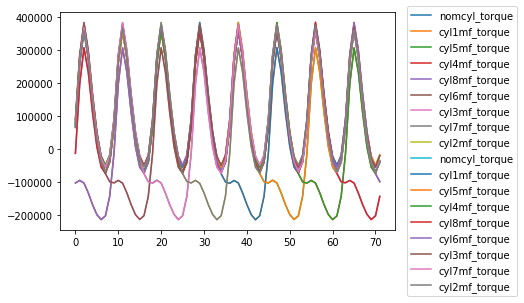

In [9]:
plt.plot((nomcyl_torque)[0], label = "nomcyl_torque")
plt.plot((cyl1mf_torque)[0], label = "cyl1mf_torque")
plt.plot((cyl5mf_torque)[0], label = "cyl5mf_torque")
plt.plot((cyl4mf_torque)[0], label = "cyl4mf_torque")
plt.plot((cyl8mf_torque)[0], label = "cyl8mf_torque")
plt.plot((cyl6mf_torque)[0], label = "cyl6mf_torque")
plt.plot((cyl3mf_torque)[0], label = "cyl3mf_torque")
plt.plot((cyl7mf_torque)[0], label = "cyl7mf_torque")
plt.plot((cyl2mf_torque)[0], label = "cyl2mf_torque")
plt.plot((nomcyl_torque)[200], label = "nomcyl_torque")
plt.plot((cyl1mf_torque)[200], label = "cyl1mf_torque")
plt.plot((cyl5mf_torque)[200], label = "cyl5mf_torque")
plt.plot((cyl4mf_torque)[200], label = "cyl4mf_torque")
plt.plot((cyl8mf_torque)[200], label = "cyl8mf_torque")
plt.plot((cyl6mf_torque)[200], label = "cyl6mf_torque")
plt.plot((cyl3mf_torque)[200], label = "cyl3mf_torque")
plt.plot((cyl7mf_torque)[200], label = "cyl7mf_torque")
plt.plot((cyl2mf_torque)[200], label = "cyl2mf_torque")
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1.05), ncol=1)
plt.show()


In [10]:
v8_df = pd.DataFrame(np.transpose(x))
v8_tt_df = pd.DataFrame(np.transpose(y))
v8_df

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,71160.978583,265820.218416,362097.221545,277357.564422,142503.196970,31062.725924,-41599.230626,-68941.210455,-36716.711562,71805.436696,...,-37585.896945,71839.644713,266477.808737,362622.775259,276444.965474,143318.431171,31459.331641,-41006.622549,-69146.838850,-37254.014369
1,71179.182934,266220.049548,362166.888731,277324.340477,143198.914969,31356.725149,-40205.837487,-69200.376841,-37157.091841,70633.984057,...,-37324.653159,71233.578543,266787.906329,362128.089471,276104.449661,142898.965528,30500.683703,-40605.558394,-68358.770661,-36945.367980
2,71549.044900,265225.893442,362378.725664,276683.405024,143017.133644,31538.523385,-40437.004840,-68431.973715,-37458.975332,71349.817269,...,-37372.688467,71456.452140,266282.643061,363119.077022,276650.161122,143610.899845,31574.755645,-40918.855570,-69276.343904,-36999.402784
3,71700.710354,266009.421149,362772.346716,276949.162239,143625.933713,31059.219687,-40964.018660,-68847.785141,-37990.953643,70997.363853,...,-37527.117336,71208.216584,265892.492054,362603.035749,277189.701221,143172.850739,30937.705547,-40513.313175,-68257.208728,-36025.914383
4,71089.053303,265542.769245,362317.330179,276370.355515,143801.680618,30833.524782,-41124.810943,-68770.545303,-37196.141021,70839.156566,...,-36539.884047,72317.344889,266044.384847,363185.153360,277585.888788,143552.876075,30235.878484,-40782.254009,-68621.933727,-37377.877061
5,71650.101246,266632.682546,362947.353612,276696.127420,143443.608201,31264.840036,-40814.446787,-68957.423984,-37006.342302,71325.516130,...,-37228.296311,71468.964878,265793.616154,362092.414602,276573.892973,143547.425621,30376.153526,-40080.601076,-68936.991391,-37024.422129
6,71426.170374,266066.379305,362894.059209,276289.394969,143279.428652,30936.199374,-41194.339954,-69160.361930,-36841.457612,71607.626274,...,-36746.962751,71394.800967,265995.821748,362580.808813,276846.653095,143691.961957,31440.132379,-40854.093998,-68485.542083,-36667.310018
7,71306.239355,266341.771722,363197.459651,276913.777340,143710.068690,30525.159540,-40225.050434,-68584.728011,-36790.807098,71712.545751,...,-37305.768794,72317.728950,266582.212421,362666.240427,276757.300681,143398.264670,31624.796701,-40884.793528,-69189.734459,-36251.576907
8,71446.771183,265782.205052,362503.147350,276362.126848,142901.105182,30862.241096,-40645.639906,-68638.771936,-37176.389117,72090.622564,...,-37525.511500,71967.033952,266272.814367,362624.869924,276511.710498,143305.113933,31126.246896,-39856.383607,-68701.537033,-37494.816560
9,71763.072822,266459.186043,362054.629296,276854.105760,143581.845532,30771.041046,-40053.464196,-68721.038952,-37238.368577,71772.328575,...,-37200.604998,71689.182153,266366.128980,362797.412383,277153.785295,142922.245620,31092.095766,-40592.524431,-68465.957766,-36776.882602


In [11]:
v8_tt_df

,0,1,2,3,4,5,6,7
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0


In [12]:
x_train, x_test, y_train, y_test = train_test_split(v8_df,v8_tt_df, test_size = 0.3, random_state=0)

In [13]:
np.shape(x_train), np.shape(y_train)

((5544, 72), (5544, 8))

In [14]:
np.shape(x_test), np.shape(y_test )

((2376, 72), (2376, 8))

In [15]:
from sklearn.svm import SVC
classifier = RandomForestClassifier(n_jobs=2, random_state = 0 )
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
y_pred = classifier.predict(x_test)

In [17]:
y_pred = pd.DataFrame(y_pred)
y_pred

,0,1,2,3,4,5,6,7
0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
y_test

,0,1,2,3,4,5,6,7
7303,0,1,0,1,1,0,1,0
6146,0,0,0,0,0,0,0,1
1977,0,1,0,0,0,0,0,0
5913,0,0,0,0,0,0,0,1
6589,1,0,1,0,0,1,0,1
4238,0,0,0,0,1,0,0,0
244,0,0,0,0,0,0,0,0
4857,0,0,0,0,0,1,0,0
7859,0,1,0,1,1,0,1,0
1277,1,0,0,0,0,0,0,0


In [ ]:
y_pred.to_csv('y_pred.csv')
y_test.to_csv('y_test.csv')